# Projeto Wine Scrapper

> Um sistema para extração de dados e análise em sites de comércio e avaliação de vinhos

***


## Parte 1 - Web scrapper do site da Wine.com.br

### 1.1. Testes com páginas individuais

In [1]:
import requests
page = requests.get("https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p1.html")

from bs4 import BeautifulSoup as bs

soup = bs(page.content, 'html.parser')


product = soup.find('article', class_='ProductDisplay')

ProductName = product.find('div', class_='ProductDisplay-name')
product_name_a = ProductName.find('a')

print(product_name_a['title'])
print("https://wine.com.br" + product_name_a['href'])

country = product.find(class_="Country")
print(country.span.text)

wine_type = product.find(class_="ProductDisplay-type")
print(wine_type.span.text)

wine_description = product.find(class_="ProductDisplay-descriptionText")
print(wine_description.text)
      
# print(product_name_a.prettify())

Pérez Cruz Limited Edition D.O. Valle del Maipo Cabernet Franc 2016
https://wine.com.br/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html
Chile
tinto
Frutado, taninos presentes, médio corpo, fresco, amadeirado, especiarias


In [2]:
# Buscando Notas e numero de avaliações
import re

wine_rating = product.find('div',class_='Rating')
wine_evaluation_tag = wine_rating.find('evaluation-tag')
if (wine_evaluation_tag):
    wine_evaluation = re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group()
    wine_rating_count = re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group()
else:
    wine_evaluation = None
    wine_rating_count = 0

print(str(wine_rating))
print(wine_evaluation)
print(wine_rating_count)

<div class="Rating">
<div class="Rating-stars">
<div class="vue-evaluation-tag">
<evaluation-tag :evaluation="4.0"></evaluation-tag>
</div>
</div>
<a class="Rating-count" href="/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html#Comments">(7)</a>
</div>
4.0
7


In [3]:
# Buscando Preço

price_box = product.find(class_="ProductDisplay-priceBox")

lowest_price = price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text
full_price = price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text
print(lowest_price)
print(full_price)

discount = 1-float(lowest_price)/float(full_price)
print(discount)

145.76
180.90
0.1942509673852958


In [4]:
# Buscando Número de Páginas

pages_list = soup.find('div', class_='Pagination').ul.find_all('li')
int(pages_list[len(pages_list)-1].a.text)

47

In [5]:
# Juntando tudo para processar a lista de uma só página

wine_list = soup.find('div', class_='ProductList-content').ul.find_all('li')

for wine_item in wine_list:
    wine = wine_item.find('article', class_='ProductDisplay')

    wine_name = wine.find('div', class_='ProductDisplay-name').a['title']
    wine_link = "https://wine.com.br" + wine.find('div', class_='ProductDisplay-name').a['href']
    wine_country = wine.find(class_="Country").span.text
    wine_type = wine.find(class_="ProductDisplay-type").span.text
    wine_description = wine.find(class_="ProductDisplay-descriptionText").text
    
    wine_rating = wine.find('div',class_='Rating')
    wine_evaluation_tag = wine_rating.find('evaluation-tag')
    if (wine_evaluation_tag):
        wine_evaluation = re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group()
        wine_rating_count = re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group()
    else:
        wine_evaluation = None
        wine_rating_count = 0
    
    price_box = wine.find(class_="ProductDisplay-priceBox")

    lowest_price = price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text
    full_price = price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text
    discount = 1-float(lowest_price)/float(full_price)
    
    
    print(wine_name,";", wine_evaluation, ";", wine_rating_count, ";", wine_country, ";", wine_type, ";", lowest_price, ";", full_price, ";", discount,";", wine_description, ";", wine_link)

Pérez Cruz Limited Edition D.O. Valle del Maipo Cabernet Franc 2016 ; 4.0 ; 7 ; Chile ; tinto ; 145.76 ; 180.90 ; 0.1942509673852958 ; Frutado, taninos presentes, médio corpo, fresco, amadeirado, especiarias ; https://wine.com.br/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html
Finca La Chamiza Martín Alsina Malbec 2014 ; None ; 0 ; Argentina ; tinto ; 292.82 ; 495.90 ; 0.4095180479935471 ; Frutado, amadeirado, corpo de médio para encorpado, taninos presentes, acidez agradável ; https://wine.com.br/vinhos/finca-la-chamiza-martin-alsina-malbec-2014/prod20028.html
Domaine L'Ostal Cazes Grand Vin 2015 ; None ; 0 ; França ; tinto ; 258.71 ; 335.90 ; 0.22980053587377192 ; Encorpado, boa acidez, taninos macios ; https://wine.com.br/vinhos/domaine-l-ostal-cazes-grand-vin-2015/prod20143.html
Echo de Lynch-Bages A.O.C. Pauillac 2014 ; None ; 0 ; França ; tinto ; 721.06 ; 1056.90 ; 0.3177594852871607 ; Exuberante, encorpado, taninos presentes, boa acidez, 

In [22]:
import requests
from lxml.html import fromstring
from itertools import cycle
import traceback
import timeit

def get_proxies():
    url = 'https://free-proxy-list.net/'
    start = timeit.timeit()
    response = requests.get(url)
    end = timeit.timeit()
    print(end - start)
    parser = fromstring(response.text)
    #print (response.text)
    proxies = set()
    for i in parser.xpath('//tbody/tr')[:20]:
        #print(i.xpath('.//td[7][contains(text(),"yes")]'))
        if i.xpath('.//td[7][contains(text(),"yes")]'):
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.add(proxy)
    return proxies

proxies = get_proxies()
print(proxies)
proxy_pool = cycle(proxies)

url = 'https://httpbin.org/ip'
for i in range(1,11):
    #Get a proxy from the pool
    proxy = next(proxy_pool)
    print("Request #%d"%i)
    try:
        start = timeit.timeit()
        response = requests.get(url,proxies={"http": proxy, "https": proxy})
        end = timeit.timeit()
        print (end - start)
        print(response.json())
    except:
        #Most free proxies will often get connection errors. You will have retry the entire request using another proxy to work. 
        #We will just skip retries as its beyond the scope of this tutorial and we are only downloading a single url 
        print("Skipping. Connnection error")

-0.0018271599992658594
{'103.83.116.210:55443', '109.239.243.211:23500', '123.195.152.139:32287', '194.8.146.167:50510', '27.255.13.134:49328'}
Request #1
-0.0012395980002111173
{'origin': '103.15.240.89'}
Request #2
Skipping. Connnection error
Request #3
Skipping. Connnection error
Request #4
Skipping. Connnection error
Request #5
Skipping. Connnection error
Request #6
Skipping. Connnection error
Request #7
0.0003484030003164662
{'origin': '109.239.243.211'}
Request #8
Skipping. Connnection error
Request #9
-0.0026197279994448763
{'origin': '194.8.146.167'}
Request #10
Skipping. Connnection error


In [8]:
URL_RAIZ="https://www.wine.com.br"
URL_BASE = URL_RAIZ+"/vinhos/{0}/cVINHOS-atTIPO_{1}-p{2}.html"

tipos_de_vinho = ['TINTO','BRANCO']

for tipo in tipos_de_vinho:

    current_page = 1
    print(URL_BASE.format(tipo.lower(),tipo,current_page))

https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p1.html
https://www.wine.com.br/vinhos/branco/cVINHOS-atTIPO_BRANCO-p1.html


### 1.2. Sistema Winescrapper

In [9]:
# Webscrapper do Site da Wine
# Cabeçalhos e Imports

from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re
import time

URL_RAIZ="https://www.wine.com.br"
URL_BASE = URL_RAIZ+"/vinhos/{0}/cVINHOS-atTIPO_{1}-p{2}.html"


HEADERS = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 '
                   '(KHTML, like Gecko) Chrome/78.0.3904.87 Safari/537.36'),
    'Connection':'close'
}



In [10]:
# Funções

def get_num_pages(soup):
    
    pages_list = soup.find('div', class_='Pagination').ul.find_all('li')
    num_pages = int(pages_list[len(pages_list)-1].a.text) + 1
    
    return num_pages

def scrape_soup(soup):
    
    list_name=[]
    list_link, list_country, list_type, list_description= [], [], [], []
    list_evaluation, list_rating_count= [], []
    list_lowest_price, list_full_price, list_discount= [], [], []
    
    wine_list = soup.find('div', class_='ProductList-content').ul.find_all('li')

    for wine_item in wine_list:
        
        try:
            wine = wine_item.find('article', class_='ProductDisplay')

            wine_name = wine.find('div', class_='ProductDisplay-name').a['title']
            wine_link = "wine.com.br" + wine.find('div', class_='ProductDisplay-name').a['href']
            wine_country = wine.find(class_="Country").span.text
            wine_type = wine.find(class_="ProductDisplay-type").span.text
            wine_description = wine.find(class_="ProductDisplay-descriptionText").text
        
            wine_rating = wine.find('div',class_='Rating')
            wine_evaluation_tag = wine_rating.find('evaluation-tag')
            if (wine_evaluation_tag):
                wine_evaluation = float(re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group())
                wine_rating_count = float(re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group())
            else:
                wine_evaluation = 0
                wine_rating_count = 0
    
        
            price_box = wine.find(class_="ProductDisplay-priceBox")

            lowest_price = float(price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text)
            full_price = float(price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text)
            discount = 1-float(lowest_price)/float(full_price)
        except:
            if wine_name:
                print('skip incomplete item:', wine_name)
                continue
            else:
                print("skip incomplete item: no name")
                continue
        
        list_name.append(wine_name)
        list_link.append(wine_link)
        list_country.append(wine_country)
        list_type.append(wine_type)
        list_description.append(wine_description)
        
        list_evaluation.append(wine_evaluation)
        list_rating_count.append(wine_rating_count)

        list_lowest_price.append(lowest_price)
        list_full_price.append(full_price)
        list_discount.append(discount)
        
        ###print(wine_name,";", wine_evaluation, ";", wine_rating_count, ";", wine_country, ";", wine_type, ";", lowest_price, ";", full_price, ";", discount,";", wine_link)
    
    df = pd.DataFrame({
        'wine_name': list_name,
        'link': list_link,
        'country': list_country,
        'type': list_type,
        'description': list_description,
        'evaluation': list_evaluation,
        'rating_count': list_rating_count,
        'lowest_price': list_lowest_price,
        'full_price': list_full_price,
        'discount': list_discount
    })
    
    return df
        
    

def get_soup(page_url, retry_count=0):
    
    session= requests.Session()
    session.trust_env = False
    
    print("Iniciando session_get")
    
    try:
        response = session.get(page_url, headers=HEADERS)
        print("\nScraping page:",page_url," = ", response)
        soup = bs(response.content, 'html.parser')
        return soup
    except:
        print("Get falhou")
        retry_count += 1
        if retry_count <= 3:
            print("retry get")
            session = requests.Session()
            get_soup(page_url, retry_count)
        else:
            raise
    
    


    


In [11]:
# Módulo Principal - Processamento do Site

wine_df = pd.DataFrame(columns=['wine_name','link','country','type','description','evaluation','rating_count','lowest_price','full_price','discount'])

tipos_de_vinho = ['TINTO','BRANCO']

for tipo in tipos_de_vinho:

    pages_to_scrape = 4

    current_page = 1


    while (current_page != pages_to_scrape):
    
        #print("vinhos {}: Iniciando get_soup pagina {}").format(tipo, current_page)
        print('vinho ', tipo, ': Iniciando get_soup pagina ', current_page)
    
        wine_soup = get_soup(URL_BASE.format(tipo.lower(),tipo, current_page))
    
        if current_page == 1:
            pages_to_scrape = get_num_pages(wine_soup)
    
        new_df = scrape_soup(wine_soup)
        wine_df= wine_df.append(new_df, ignore_index=True)
    
        ###print(current_page)
    
        time.sleep(10)
        current_page += 1
    
print("Scrape finished.")
wine_df



vinho  TINTO : Iniciando get_soup pagina  1
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p1.html  =  <Response [200]>
vinho  TINTO : Iniciando get_soup pagina  2
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p2.html  =  <Response [200]>
vinho  TINTO : Iniciando get_soup pagina  3
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p3.html  =  <Response [200]>
vinho  TINTO : Iniciando get_soup pagina  4
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p4.html  =  <Response [200]>
vinho  TINTO : Iniciando get_soup pagina  5
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p5.html  =  <Response [200]>
vinho  TINTO : Iniciando get_soup pagina  6
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p6.html  =  <Re

vinho  TINTO : Iniciando get_soup pagina  41
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p41.html  =  <Response [200]>
vinho  TINTO : Iniciando get_soup pagina  42
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p42.html  =  <Response [200]>
skip incomplete item: WineBox Descubra o Novo Família Dark Horse
skip incomplete item: WineBox Descubra o Novo Tintos
vinho  TINTO : Iniciando get_soup pagina  43
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p43.html  =  <Response [200]>
skip incomplete item: Winebox America do Sul
skip incomplete item: Winebox O Melhor dos Mundos
skip incomplete item: WineBox Familia Urmeneta
skip incomplete item: WineBox Familia Root: 1
skip incomplete item: WineBox Chilenos
skip incomplete item: WineBox Familia Altivo
skip incomplete item: WineBox Familia Partridge
skip incomplete item: WineBox Descubra o Novo Afr

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
0,Pinhal Da Torre Special D.O.C. Tejo 2008,wine.com.br/vinhos/pinhal-da-torre-special-d-o...,Portugal,tinto,"Maduro, elegante, boa acidez, taninos macios, ...",5.0,1.0,826.94,999.9,0.172977
1,Finca La Chamiza Martín Alsina Malbec 2014,wine.com.br/vinhos/finca-la-chamiza-martin-als...,Argentina,tinto,"Frutado, amadeirado, corpo de médio para encor...",5.0,1.0,323.41,495.9,0.347832
2,Tormentoso Cabernet Sauvignon 2016,wine.com.br/vinhos/tormentoso-cabernet-sauvign...,África do Sul,tinto,"Médio corpo, taninos presentes, boa acidez, am...",3.0,47.0,88.12,122.9,0.282994
3,Echo de Lynch-Bages A.O.C. Pauillac 2014,wine.com.br/vinhos/echo-de-lynch-bages-a-o-c-p...,França,tinto,"Exuberante, encorpado, taninos presentes, boa ...",0.0,0.0,721.06,1056.9,0.317759
4,Suolo Rosso D.O.P. Primitivo di Manduria 2016,wine.com.br/vinhos/suolo-rosso-d-o-p-primitivo...,Itália,tinto,"Frutado, médio corpo, acidez agradável, tanino...",4.5,13.0,179.88,219.9,0.181992
...,...,...,...,...,...,...,...,...,...,...
489,Canepa Novísimo Chardonnay 2019,wine.com.br/vinhos/canepa-novisimo-chardonnay-...,Chile,branco,"Leve, boa acidez, frutado",3.5,3.0,39.90,39.9,0.000000
490,William Hill Central Coast Chardonnay 2017,wine.com.br/vinhos/william-hill-central-coast-...,Estados Unidos,branco,"Leve, acidez agradável, frutado, leve amadeirado",0.0,0.0,169.29,225.9,0.250598
491,Fantinel Friulano Borgo Tesis Doc Friuli Branc...,wine.com.br/vinhos/fantinel-friulano-borgo-tes...,Itália,branco,"Frutado, acidez agradável, boa presença em boca",3.0,1.0,139.90,139.9,0.000000
492,Cuna del Sol Reserva Viognier 2019,wine.com.br/vinhos/cuna-del-sol-reserva-viogni...,Chile,branco,"Equilibrado, final persistente e excelente acidez",4.5,5.0,90.90,90.9,0.000000


In [12]:
# Análise do dados

wine_deals = wine_df.loc[(wine_df.rating_count>=36) & (wine_df.evaluation >= 4.2) & (wine_df.lowest_price < 66.20)]
wine_deals

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
248,Partridge Flying Malbec 2019,wine.com.br/vinhos/partridge-flying-malbec-201...,Argentina,tinto,"Corpo de leve para médio, frutado, acidez agra...",4.5,105.0,51.65,59.9,0.137730
249,Señorío de Ayud Cabernet Sauvignon Syrah 2018,wine.com.br/vinhos/senorio-de-ayud-cabernet-sa...,Espanha,tinto,"Frutado, médio corpo, acidez agradável, tanino...",4.5,105.0,52.82,60.9,0.132677
288,V9 Reserva Carménère 2018,wine.com.br/vinhos/v9-reserva-carmenere-2018/p...,Chile,tinto,"Corpo de leve para médio, taninos presentes, a...",4.5,120.0,52.82,62.9,0.160254
312,V9 Reserva Cabernet Sauvignon 2018,wine.com.br/vinhos/v9-reserva-cabernet-sauvign...,Chile,tinto,"Frutado, bom corpo, taninos presentes, fresco",4.5,114.0,52.82,62.9,0.160254
345,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,669.0,43.41,54.9,0.209290
353,Corello D.O.C. Sicília Nero dAvola 2017,wine.com.br/vinhos/corello-d-o-c-sicilia-nero-...,Itália,tinto,"Corpo de leve para médio, fresco, taninos sedosos",4.5,113.0,62.24,75.9,0.179974
427,Root: 1 Sauvignon Blanc 2018,wine.com.br/vinhos/root-1-sauvignon-blanc-2018...,Chile,branco,"Leve, cítrico, jovem, fácil de beber, boa acidez",4.5,54.0,52.82,64.9,0.186133
473,Toro Loco D.O.P. Utiel-Requena Viura Sauvignon...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,branco,"leve, fresco, cítrico, fácil de beber",4.5,107.0,43.41,55.9,0.223435


In [13]:
wine_exotic = wine_df.loc[~wine_df.country.isin(['Chile','França','Espanha','Argentina','Itália','Portugal','Brasil','Estados Unidos','Uruguai'])]
wine_exotic.loc[wine_exotic.country == 'China']

#wine_exotic.iloc[2].link

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
428,Chateau Moser XV Blanc de Noir 2018,wine.com.br/vinhos/chateau-moser-xv-blanc-de-n...,China,branco,"Fresco, leve, boa acidez e vigor",4.0,29.0,75.18,85.9,0.124796


In [14]:
# Exemplo do uso de Describe
wine_df.lowest_price.describe()

count      494.000000
mean       416.302996
std       1435.500314
min         35.900000
25%         76.012500
50%         99.900000
75%        183.185000
max      15870.470000
Name: lowest_price, dtype: float64

In [15]:
# Mais um exemplo de Describe

wine_df.loc[wine_df.evaluation > 0].describe()

,evaluation,rating_count,lowest_price,full_price,discount
count,367.000000,367.000000,367.000000,367.000000,367.000000
mean,4.031335,30.166213,203.852343,270.824469,0.162383
std,0.632433,92.787684,682.203178,1051.441340,0.138212
min,1.000000,1.000000,35.900000,35.900000,0.000000
25%,4.000000,4.000000,74.465000,87.900000,0.000000
50%,4.000000,12.000000,94.000000,119.210000,0.168846
75%,4.500000,33.500000,140.300000,179.700000,0.265573
max,5.000000,1568.000000,9303.410000,14794.900000,0.517130


In [16]:
#Exemplo de funções de sumário

print(wine_df.country.describe())
print(wine_df.rating_count.mean())
print(wine_df.country.unique())

count       494
unique       16
top       Chile
freq         96
Name: country, dtype: object
22.410931174089068
['Portugal' 'Argentina' 'África do Sul' 'França' 'Itália' 'Espanha'
 'Estados Unidos' 'Chile' 'Áustria' 'Líbano' 'Alemanha' 'Uruguai'
 'Austrália' 'Brasil' 'Hungria' 'China']


In [17]:
# Exemplo de groupby
wine_df.groupby('country').lowest_price.min()

country
Alemanha           88.12
Argentina          38.96
Austrália          90.47
Brasil             75.90
Chile              35.90
China              75.18
Espanha            43.41
Estados Unidos     54.00
França             52.82
Hungria           808.90
Itália             43.41
Líbano            161.06
Portugal           52.82
Uruguai            82.24
África do Sul      41.06
Áustria           105.76
Name: lowest_price, dtype: float64

In [18]:
# Exemplo de min
wine_deals.groupby('country').lowest_price.min()

country
Argentina    51.65
Chile        52.82
Espanha      43.41
Itália       62.24
Name: lowest_price, dtype: float64

In [19]:
# Exemplo de Apply
wine_df.groupby(['country','type']).apply(lambda df: df.loc[df.rating_count.idxmax()])

wine_name  \
country        type                                                        
Alemanha       branco         Ernst Loosen Private Reserve Riesling 2018   
               tinto   Ernst Loosen Winemakers Select Pfalz Edition P...   
Argentina      branco                   Finca La Chamiza Chardonnay 2018   
               tinto                        Partridge Flying Malbec 2019   
Austrália      branco   Miles from Nowhere Sauvignon Blanc Semillon 2019   
               tinto          Yalumba Coonawarra Cabernet Sauvignon 2016   
Brasil         branco      Lidio Carraro Faces do Brasil Chardonnay 2017   
               tinto         Lidio Carraro Agnus Cabernet Sauvignon 2018   
Chile          branco                       Root: 1 Sauvignon Blanc 2018   
               tinto      Pérez Cruz GSM D.O. Valle del Maipo Andes 2016   
China          branco                Chateau Moser XV Blanc de Noir 2018   
Espanha        branco  Toro Loco D.O.P. Utiel-Requena Viura Sauvignon...   
               tinto   Toro Loco D.O.P. Utiel-Requena Tinto Superior ...   
Estados Unidos branco             Chateau Souverain Sauvignon Blanc 2018   
               tinto                            Bear Flag Red Blend 2018   
França         branco  Ropiteau Frères Les Plants Nobles Chardonnay 2018   
               tinto                                            Beaupont   
Hungria        branco                  Tokaji Pajzos Icewine 2003 375 ml   
Itália         branco        Cent'Are I.G.P. Terre Siciliane Bianco 2017   
               tinto                                  Campo Al Moro 2016   
Líbano         tinto                     Chateau Oumsiyat Red Syrah 2015   
Portugal       branco         Cavalo Bravo Private Selection Branco 2017   
               tinto              Quinta de São João Cuvée RB Tinto 2017   
Uruguai        branco                 Viñedo de los Vientos Estival 2018   
               tinto   Viñedo de los Vientos Angel's Cuvée Ripasso de...   
África do Sul  branco                          Natana Cuvée Blanche 2017   
               tinto          Lievland Vineyards Bush Vine Pinotage 2017   
Áustria        branco                Gruner Veltliner Classic White 2018   
               tinto                           Zweigelt Classic Red 2017   

                                                                    link  \
country        type                                                        
Alemanha       branco  wine.com.br/vinhos/ernst-loosen-private-reserv...   
               tinto   wine.com.br/vinhos/ernst-loosen-winemakers-sel...   
Argentina      branco  wine.com.br/vinhos/finca-la-chamiza-chardonnay...   
               tinto   wine.com.br/vinhos/partridge-flying-malbec-201...   
Austrália      branco  wine.com.br/vinhos/miles-from-nowhere-sauvigno...   
               tinto   wine.com.br/vinhos/yalumba-coonawarra-cabernet...   
Brasil         branco  wine.com.br/vinhos/lidio-carraro-faces-do-bras...   
               tinto   wine.com.br/vinhos/lidio-carraro-agnus-caberne...   
Chile          branco  wine.com.br/vinhos/root-1-sauvignon-blanc-2018...   
               tinto   wine.com.br/vinhos/perez-cruz-gsm-d-o-valle-de...   
China          branco  wine.com.br/vinhos/chateau-moser-xv-blanc-de-n...   
Espanha        branco  wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...   
               tinto   wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...   
Estados Unidos branco  wine.com.br/vinhos/chateau-souverain-sauvignon...   
               tinto   wine.com.br/vinhos/bear-flag-red-blend-2018/pr...   
França         branco  wine.com.br/vinhos/ropiteau-freres-les-plants-...   
               tinto          wine.com.br/vinhos/beaupont/prod22980.html   
Hungria        branco  wine.com.br/vinhos/tokaji-pajzos-icewine-2003-...   
Itália         branco  wine.com.br/vinhos/cent-are-i-g-p-terre-sicili...   
               tinto   wine.com.br/vinhos/campo-al-moro-2016/prod1894...   
Líbano         tinto   wine.com.br

In [20]:
# Exemplo de sort

sorted_wines = wine_deals.sort_values(by=['lowest_price','evaluation'])
sorted_wines

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
345,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,669.0,43.41,54.9,0.209290
473,Toro Loco D.O.P. Utiel-Requena Viura Sauvignon...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,branco,"leve, fresco, cítrico, fácil de beber",4.5,107.0,43.41,55.9,0.223435
248,Partridge Flying Malbec 2019,wine.com.br/vinhos/partridge-flying-malbec-201...,Argentina,tinto,"Corpo de leve para médio, frutado, acidez agra...",4.5,105.0,51.65,59.9,0.137730
249,Señorío de Ayud Cabernet Sauvignon Syrah 2018,wine.com.br/vinhos/senorio-de-ayud-cabernet-sa...,Espanha,tinto,"Frutado, médio corpo, acidez agradável, tanino...",4.5,105.0,52.82,60.9,0.132677
288,V9 Reserva Carménère 2018,wine.com.br/vinhos/v9-reserva-carmenere-2018/p...,Chile,tinto,"Corpo de leve para médio, taninos presentes, a...",4.5,120.0,52.82,62.9,0.160254
312,V9 Reserva Cabernet Sauvignon 2018,wine.com.br/vinhos/v9-reserva-cabernet-sauvign...,Chile,tinto,"Frutado, bom corpo, taninos presentes, fresco",4.5,114.0,52.82,62.9,0.160254
427,Root: 1 Sauvignon Blanc 2018,wine.com.br/vinhos/root-1-sauvignon-blanc-2018...,Chile,branco,"Leve, cítrico, jovem, fácil de beber, boa acidez",4.5,54.0,52.82,64.9,0.186133
353,Corello D.O.C. Sicília Nero dAvola 2017,wine.com.br/vinhos/corello-d-o-c-sicilia-nero-...,Itália,tinto,"Corpo de leve para médio, fresco, taninos sedosos",4.5,113.0,62.24,75.9,0.179974


In [21]:
# Exemplo de iterator em DataFrame

for index, row in sorted_wines.iterrows():
    print(row.wine_name, "\t", row.link)



Toro Loco D.O.P. Utiel-Requena Tinto Superior 2018 	 wine.com.br/vinhos/toro-loco-d-o-p-utiel-requena-tinto-superior-2018/prod23299.html
Toro Loco D.O.P. Utiel-Requena Viura Sauvignon Blanc 2018 	 wine.com.br/vinhos/toro-loco-d-o-p-utiel-requena-viura-sauvignon-blanc-2018/prod22599.html
Partridge Flying Malbec 2019 	 wine.com.br/vinhos/partridge-flying-malbec-2019/prod23315.html
Señorío de Ayud Cabernet Sauvignon Syrah 2018 	 wine.com.br/vinhos/senorio-de-ayud-cabernet-sauvignon-syrah-2018/prod22834.html
V9 Reserva Carménère 2018 	 wine.com.br/vinhos/v9-reserva-carmenere-2018/prod22181.html
V9 Reserva Cabernet Sauvignon 2018 	 wine.com.br/vinhos/v9-reserva-cabernet-sauvignon-2018/prod22182.html
Root: 1 Sauvignon Blanc 2018 	 wine.com.br/vinhos/root-1-sauvignon-blanc-2018/prod22174.html
Corello D.O.C. Sicília Nero dAvola 2017 	 wine.com.br/vinhos/corello-d-o-c-sicilia-nero-davola-2017/prod22056.html


### 1.3. Análise Descritiva - Wine


In [22]:
# Gráficos

import matplotlib.pyplot as plt

#wine_df.boxplot(column=wine_df.groupby('country'))
wine_df.groupby('country')['lowest_price'].describe()


,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Alemanha,5.0,93.530000,5.232915,88.12,88.1200,95.180,96.3500,99.88
Argentina,62.0,102.045323,77.374069,38.96,54.3675,72.490,102.7075,451.65
Austrália,8.0,116.036250,16.948273,90.47,101.0600,120.900,124.8000,136.50
Brasil,5.0,127.320000,60.138440,75.90,84.0000,114.900,135.9000,225.90
Chile,96.0,129.776771,144.278522,35.90,64.5900,85.745,135.8525,1058.71
China,1.0,75.180000,NaN,75.18,75.1800,75.180,75.1800,75.18
Espanha,70.0,110.667714,101.090643,43.41,69.0750,85.245,122.5950,777.53
Estados Unidos,36.0,589.181667,1557.653207,54.00,108.1200,154.000,224.8825,8938.71
França,96.0,1391.531562,2906.664178,52.82,95.1800,208.710,603.9975,15870.47


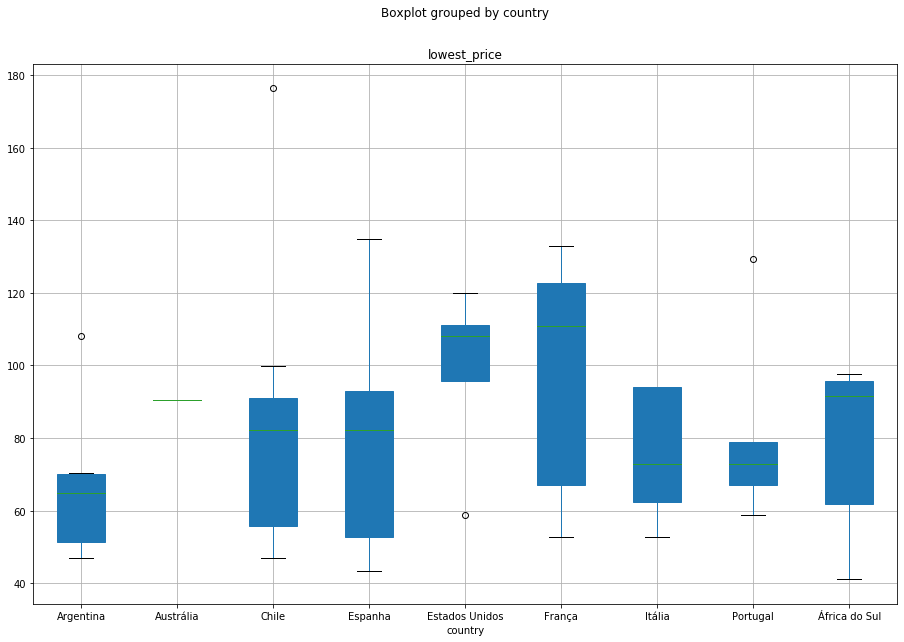

In [23]:
wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 200.0) & (wine_df.rating_count > 34.0)].boxplot(by='country',column=['lowest_price'], figsize=(15,10), patch_artist=True)

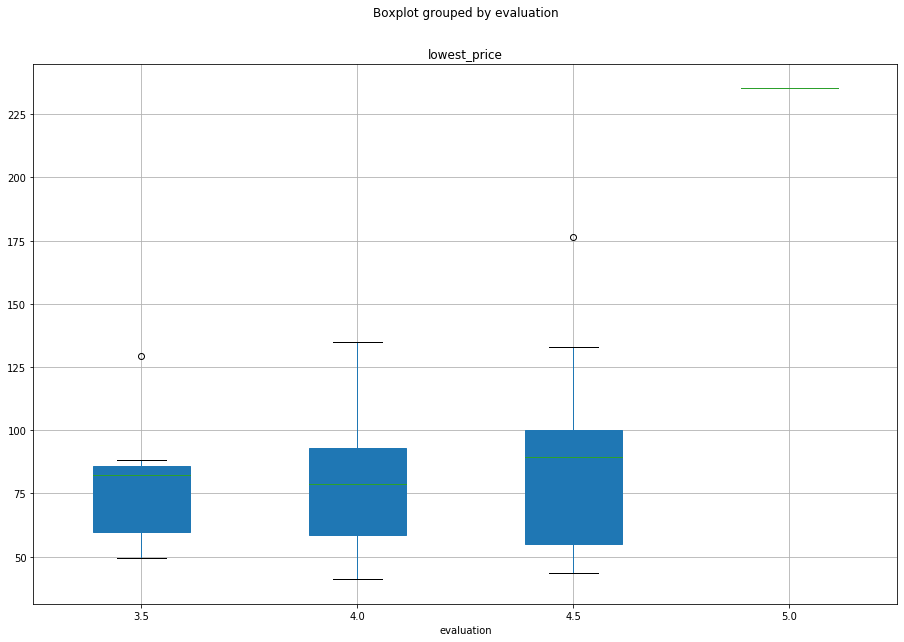

In [24]:
wine_plot = wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 1000.0) & (wine_df.rating_count > 34.0)]
wine_plot.boxplot(by='evaluation',column=['lowest_price'], figsize=(15,10), patch_artist=True)

In [25]:
wine_df.evaluation.corr(wine_df.lowest_price)

-0.22930018699041388

## Parte 2 - Busca no Vivino

### 2.1. Testes Individuais

#### URL Encoding para buscar no Vivino


In [19]:
import urllib.parse

wine_deals = wine_df.loc[(wine_df.rating_count>=36) & (wine_df.evaluation >= 4.2)]
sorted_wines = wine_deals.sort_values(by=['lowest_price','evaluation'])

#row = next(sorted_wines.iterrows())[1]
#Pegando o segundo da lista
row = sorted_wines.iloc[0]

query_url = urllib.parse.quote(row.wine_name)
row.wine_name

#for index, row in sorted_wines.iterrows():
#    query_url = urllib.parse.quote(row.wine_name)
#    print(query_url.replace("%20","+"), "\t", 'https://'+row.link)

'Toro Loco D.O.P. Utiel-Requena Tinto Superior 2018'

In [20]:
new_url = 'https://www.vivino.com/search/wines?q='+query_url.replace("%20","+")
new_url

'https://www.vivino.com/search/wines?q=Toro+Loco+D.O.P.+Utiel-Requena+Tinto+Superior+2018'

In [21]:
row.link

'wine.com.br/vinhos/toro-loco-d-o-p-utiel-requena-tinto-superior-2018/prod23299.html'

#### Busca no Vivino


In [ ]:
vivino_soup = get_soup(new_url)

#print(vivino_soup.body.prettify())

In [ ]:
vivino_search_item = vivino_soup.find('div', class_="wine-card__content")

vivino_name = vivino_search_item.find('span', class_="wine-card__name").text.replace("\n","")
print(vivino_name)

vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
try:
    vivino_average_score = float(vivino_average_score_txt.replace(",","."))
except:
    vivino_average_score = vivino_average_score_txt
print(vivino_average_score)

try:
    vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
    vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
except:
    vivino_rating = None
print(vivino_rating)

vivino_price = vivino_search_item.find('div', class_="wine-price")
vivino_price

#### Tentando com Selenium

In [26]:
from selenium import webdriver

browser = webdriver.Chrome('C:\\Users\\gmendonc\\Dev\\Scrapper\\winescrapper\\chromedriver_win32\\chromedriver')
browser.get(new_url)

vivino_soup_byselenium = bs(browser.page_source,'html.parser')

vivino_search_item = vivino_soup_byselenium.find('div', class_="wine-card__content")


NameError: name 'new_url' is not defined

In [ ]:
vivino_name_card = vivino_search_item.find('span', class_="wine-card__name")
vivino_name = vivino_name_card.text.replace("\n","")
print(vivino_name)

vivino_link = 'www.vivino.com'+vivino_name_card.a['href']
print(vivino_link)

vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
try:
    vivino_average_score = float(vivino_average_score_txt.replace(",","."))
except:
    vivino_average_score = vivino_average_score_txt
print(vivino_average_score)

try:
    vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
    vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
except:
    vivino_rating = None
print(vivino_rating)

try:
    vivino_price_txt = vivino_search_item.find('span', class_="wine-price-value").text
    vivino_price = float(vivino_price_txt.replace(",","."))
except:
    vivino_price = None
print(vivino_price)

In [ ]:
browser.close()

### 2.1. Prova de Conceito

> Busca vinhos do dataframe da wine no vivino, acha os dados e cria um novo dataframe.

In [27]:
from selenium import webdriver
from time import perf_counter
import urllib.parse

VIVINO_SEARCH_URL = 'https://www.vivino.com/search/wines?q='

browser = webdriver.Chrome('C:\\Users\\gmendonc\\Dev\\Scrapper\\winescrapper\\chromedriver_win32\\chromedriver')

reference_df = wine_df

lst_vivino_name, lst_vivino_link, lst_vivino_score, lst_vivino_rating, lst_vivino_price = [], [], [], [], []
lst_original_name = []

for index, row in reference_df.iterrows():
    
    query_url = urllib.parse.quote(row.wine_name)
    new_url = VIVINO_SEARCH_URL+query_url.replace("%20","+")
    
    print("Searching...", new_url)
    
    start_time = perf_counter()
    
    try:
        browser.get(new_url)
        vivino_soup_byselenium = bs(browser.page_source,'html.parser')
        vivino_search_item = vivino_soup_byselenium.find('div', class_="wine-card__content")
        vivino_name_card = vivino_search_item.find('span', class_="wine-card__name")
        vivino_name = vivino_name_card.text.replace("\n","")
        lst_original_name.append(row.wine_name)
        lst_vivino_name.append(vivino_name)

        vivino_link = 'www.vivino.com'+vivino_name_card.a['href']
        lst_vivino_link.append(vivino_link)

        vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
        try:
            vivino_average_score = float(vivino_average_score_txt.replace(",","."))
        except:
            vivino_average_score = None
        lst_vivino_score.append(vivino_average_score)

        try:
            vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
            vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
        except:
            vivino_rating = None
        lst_vivino_rating.append(vivino_rating)

        try:
            vivino_price_txt = vivino_search_item.find('span', class_="wine-price-value").text
            vivino_price = float(vivino_price_txt.replace(",","."))
        except:
            vivino_price = None
        lst_vivino_price.append(vivino_price)
    
        time.sleep(5)
    except:
        print("Next!")
    
    elapsed_time = perf_counter()-start_time
    print("tempo: ", elapsed_time)
        
    
browser.close()

df = pd.DataFrame({
        'wine_name' : lst_original_name,
        'vivino_name': lst_vivino_name,
        'vivino_link': lst_vivino_link,
        'vivino_score': lst_vivino_score,
        'vivino_rating': lst_vivino_rating,
        'vivino_price': lst_vivino_price,
    })

df
    
    

Searching... https://www.vivino.com/search/wines?q=Pinhal+Da+Torre+Special+D.O.C.+Tejo+2008
tempo:  12.814763983301418
Searching... https://www.vivino.com/search/wines?q=Finca+La+Chamiza+Mart%C3%ADn+Alsina+Malbec+2014
tempo:  7.023681705164563
Searching... https://www.vivino.com/search/wines?q=Tormentoso+Cabernet+Sauvignon+2016
tempo:  7.722789721495246
Searching... https://www.vivino.com/search/wines?q=Echo+de+Lynch-Bages+A.O.C.+Pauillac+2014
tempo:  7.1366576737832474
Searching... https://www.vivino.com/search/wines?q=Suolo+Rosso+D.O.P.+Primitivo+di+Manduria+2016
tempo:  6.672809393047828
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+La+Fleur-P%C3%A9trus+A.O.C.+Pomerol+2006
tempo:  7.04547027407807
Searching... https://www.vivino.com/search/wines?q=Fleur+Du+Cap+Laszlo+2015.
tempo:  6.402553619110222
Searching... https://www.vivino.com/search/wines?q=Vi%C3%B1a+Vilano+Roble+Tempranillo+2016
tempo:  6.675963040087936
Searching... https://www.vivino.com/search/wines?q=G

tempo:  6.781323437880019
Searching... https://www.vivino.com/search/wines?q=Baron+Philippe+de+Rothschild+Pays+D%C2%B4Oc+Merlot+2018
tempo:  6.332528726118653
Searching... https://www.vivino.com/search/wines?q=Baron+Philippe+de+Rothschild+Pays+D%C2%B4Oc+Cabernet+Sauvignon+2018
tempo:  6.064368820279469
Searching... https://www.vivino.com/search/wines?q=Baron+Philippe+de+Rothschild+Pays+D%C2%B4Oc+Pinot+Noir+2018
tempo:  6.291217736557428
Searching... https://www.vivino.com/search/wines?q=Domaine+de+Cibadi%C3%A8s+Bellevue+Pinot+Noir+2016
tempo:  8.728169043357411
Searching... https://www.vivino.com/search/wines?q=Carpineto+Farnito+I.G.T.+Toscana+Cabernet+Sauvignon+2013
tempo:  7.604788482497497
Searching... https://www.vivino.com/search/wines?q=Protos+Crianza+D.O.+Ribera+del+Duero+2015
tempo:  8.596979295462916
Searching... https://www.vivino.com/search/wines?q=Protos+Reserva+D.O.+Ribera+del+Duero+2014
tempo:  7.043252985646177
Searching... https://www.vivino.com/search/wines?q=Protos+Gr

tempo:  6.184150890835554
Searching... https://www.vivino.com/search/wines?q=V9+Gran+Reserva+Single+Vineyard+Carm%C3%A9n%C3%A8re+2017
tempo:  6.312528645900784
Searching... https://www.vivino.com/search/wines?q=Carpineto+D.O.C.G.+Chianti+Classico+2017
tempo:  7.1670328115660595
Searching... https://www.vivino.com/search/wines?q=Ernst+Loosen+Winemakers+Select+Pfalz+Edition+Pinot+Noir+2017
tempo:  6.9259620373677535
Searching... https://www.vivino.com/search/wines?q=Calyptra+Prestige+2015
tempo:  10.206160422878384
Searching... https://www.vivino.com/search/wines?q=Tenuta+Sant%60Antonio+dei+Gigli+D.O.C.G.+Amarone+della+Valpolicella+2013
tempo:  8.838341770162515
Searching... https://www.vivino.com/search/wines?q=Tenuta+SantAntonio+D.O.C.G.+Amarone+Della+Valpolicella+2015
tempo:  7.221846981939052
Searching... https://www.vivino.com/search/wines?q=P%C3%A1jaro+de+Buen+Ag%C3%BCero+D.O.P.+Cari%C3%B1ena+Tempranillo+2018
tempo:  6.8896008406809415
Searching... https://www.vivino.com/search/win

tempo:  6.268460721980773
Searching... https://www.vivino.com/search/wines?q=Antinori+Santa+Cristina+I.G.T.+Toscana+Rosso+2017
tempo:  7.092567507700551
Searching... https://www.vivino.com/search/wines?q=Oxford+Landing+Shiraz+2017
tempo:  6.7059874080187
Searching... https://www.vivino.com/search/wines?q=Alvarez+de+Toledo+Roble+D.O.+Bierzo+Menc%C3%ADa+2013
tempo:  6.824751443826244
Searching... https://www.vivino.com/search/wines?q=Marianne+Selena+Pinotage+2016
tempo:  6.045011575040917
Searching... https://www.vivino.com/search/wines?q=Bridlewood+Monterey+County+Pinot+Noir+2017
tempo:  5.995050936376174
Searching... https://www.vivino.com/search/wines?q=Ropiteau+Pinot+Noir+2017
tempo:  6.437648106370943
Searching... https://www.vivino.com/search/wines?q=L%60Hospitalet+De+Gazin+2010
tempo:  11.538977567866823
Searching... https://www.vivino.com/search/wines?q=Maycas+Del+Limar%C3%AD+Reserva+Sumaq+Pinot+Noir+Tinto+2017
tempo:  7.477589197455018
Searching... https://www.vivino.com/search/

tempo:  6.3195393028136095
Searching... https://www.vivino.com/search/wines?q=Familia+Barberis+Malbec+2017
tempo:  5.9787663912884454
Searching... https://www.vivino.com/search/wines?q=Tinto+Negro+Malbec+Uco+Valley+2017
tempo:  5.970248372038441
Searching... https://www.vivino.com/search/wines?q=Sagrado+D.O.C.+Douro+Tinto+2016
tempo:  6.911874361677292
Searching... https://www.vivino.com/search/wines?q=Casas+Del+Toqui+Reserva+Cabernet+Sauvignon+2018
tempo:  6.431524583606006
Searching... https://www.vivino.com/search/wines?q=Casas+del+Toqui+Terroir+Selection+Malbec+Gran+Reserva+2015
tempo:  5.95890486881035
Searching... https://www.vivino.com/search/wines?q=Casas+Del+Toqui+Reserva+Carm%C3%A9n%C3%A8re+2018
tempo:  6.030114795085865
Searching... https://www.vivino.com/search/wines?q=Alma+Tierra+Syrah+2018
tempo:  7.106271597231171
Searching... https://www.vivino.com/search/wines?q=Alma+Tierra+Carignan+2018
tempo:  5.945673334089406
Searching... https://www.vivino.com/search/wines?q=Costa

tempo:  6.261465379343463
Searching... https://www.vivino.com/search/wines?q=Toro+Loco+D.O.P.+Utiel-Requena+Tinto+Superior+2018
tempo:  6.807988509916868
Searching... https://www.vivino.com/search/wines?q=Pera+Doce+Signature+Regional+Alentejano+2016
tempo:  7.550159906568297
Searching... https://www.vivino.com/search/wines?q=Escarot+Tricicle+2019
tempo:  8.98991445518186
Searching... https://www.vivino.com/search/wines?q=Escarot+Single+2019
tempo:  6.270920851079609
Searching... https://www.vivino.com/search/wines?q=Fortant+de+France+Terroir+Littoral+Cabernet+Sauvignon+2017
tempo:  6.812731195435845
Searching... https://www.vivino.com/search/wines?q=La+Veguilla+6+Meses+em+Barrica+2016
tempo:  7.3743972282618415
Searching... https://www.vivino.com/search/wines?q=Enclos+du+Wine+Hunter+A.O.C.+Bordeaux+Rouge+2018
tempo:  6.663873148202583
Searching... https://www.vivino.com/search/wines?q=Altivo+Classic+Cabernet+Sauvignon+2019
tempo:  6.234880524944856
Searching... https://www.vivino.com/s

tempo:  6.207410359524147
Searching... https://www.vivino.com/search/wines?q=Ernst+Loosen+Private+Reserve+Riesling+2018
tempo:  6.087475146205179
Searching... https://www.vivino.com/search/wines?q=Ernst+Loosen+Pfalz+Edition+Pinot+Blanc+2018
tempo:  6.827894516723973
Searching... https://www.vivino.com/search/wines?q=Vi%C3%B1edo+de+los+Vientos+Estival+2018
tempo:  6.4036876048066915
Searching... https://www.vivino.com/search/wines?q=Godello+Luna+Beberide+Bierzo+D.O.+Branco+2017
tempo:  7.370308316490991
Searching... https://www.vivino.com/search/wines?q=CentAre+DOC+Grillo+Sicilia+Bianco+2018
tempo:  6.930446932568884
Searching... https://www.vivino.com/search/wines?q=Salentein+Killka+Chardonnay+2019
tempo:  6.294512858340568
Searching... https://www.vivino.com/search/wines?q=Cathedral+Cellar+W.O.+Western+Cape+Sauvignon+Blanc+2017
tempo:  7.145492917328738
Searching... https://www.vivino.com/search/wines?q=Antigal+UNO+Sauvignon+Blanc+2018
tempo:  6.39657339421592
Searching... https://www

tempo:  6.167482030337851
Searching... https://www.vivino.com/search/wines?q=Chateau+Souverain+Sauvignon+Blanc+2018
tempo:  7.486986693716972
Searching... https://www.vivino.com/search/wines?q=Mas+dels+Mets+D.O.+Terra+Alta+Garnacha+Blanca+2017
tempo:  8.415742128006059
Searching... https://www.vivino.com/search/wines?q=Laborie+W.O.+Western+Cape+Chardonnay+2018
tempo:  7.532416858975921
Searching... https://www.vivino.com/search/wines?q=Cavalo+Bravo+Private+Selection+Branco+2017
tempo:  6.849890922244413
Searching... https://www.vivino.com/search/wines?q=Lidio+Carraro+Faces+do+Brasil+Chardonnay+2017
tempo:  6.917153046866588
Searching... https://www.vivino.com/search/wines?q=Fantinel+Selezione+di+Famiglia+Ribolla+Gialla+2017
tempo:  6.229763368907697
Searching... https://www.vivino.com/search/wines?q=Antigal+UNO+Chardonnay+2018
tempo:  6.138833394894391
Searching... https://www.vivino.com/search/wines?q=Canepa+Nov%C3%ADsimo+Chardonnay+2019
tempo:  6.192970820105074
Searching... https://

,wine_name,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
0,Pinhal Da Torre Special D.O.C. Tejo 2008,Pinhal Da Torre Special 2008,www.vivino.com/wines/1440080,4.3,140.0,480.0
1,Finca La Chamiza Martín Alsina Malbec 2014,La Chamiza Martin Alsina Malbec 2014,www.vivino.com/wines/11537877,4.2,105.0,168.0
2,Tormentoso Cabernet Sauvignon 2016,Tormentoso Cabernet Sauvignon 2016,www.vivino.com/wines/151843176,3.5,1647.0,NaN
3,Echo de Lynch-Bages A.O.C. Pauillac 2014,Château Lynch-Bages Echo de Lynch-Bages Pauill...,www.vivino.com/wines/4436388,4.0,520.0,NaN
4,Suolo Rosso D.O.P. Primitivo di Manduria 2016,Suolo Rosso Primitivo di Manduria 2016,www.vivino.com/wines/146031350,4.2,530.0,139.4
...,...,...,...,...,...,...
489,Canepa Novísimo Chardonnay 2019,Canepa Novísimo Chardonnay 2019,www.vivino.com/wines/159878459,NaN,NaN,NaN
490,William Hill Central Coast Chardonnay 2017,William Hill Central Coast Chardonnay 2017,www.vivino.com/wines/150459415,3.7,239.0,143.9
491,Fantinel Friulano Borgo Tesis Doc Friuli Branc...,Fantinel Friulano Borgo Tesis 2018,www.vivino.com/wines/160139689,NaN,NaN,67.0
492,Cuna del Sol Reserva Viognier 2019,Cuna del Sol Reserva Merlot 2019,www.vivino.com/wines/164570491,NaN,NaN,NaN


In [28]:
result = pd.merge(reference_df, df, on='wine_name')
result.sort_values(by=['vivino_score','lowest_price'], ascending = False, na_position = 'last')

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
58,Opus One 2013,wine.com.br/vinhos/opus-one-2013/prod19463.html,Estados Unidos,tinto,"Complexo, exuberante, encorpado, boa acidez, t...",0.0,0.0,8938.71,11799.9,0.242476,Opus One Opus One 2013,www.vivino.com/wines/2794433,4.6,5396.0,NaN
105,Château Mouton Rothschild Premier Grand Cru Cl...,wine.com.br/vinhos/chateau-mouton-rothschild-p...,França,tinto,"Suculento, harmonioso, maduro, taninos aveluda...",5.0,1.0,9303.41,14794.9,0.371175,Château Mouton Rothschild Pauillac (Premier Gr...,www.vivino.com/wines/3085744,4.5,872.0,NaN
102,Château Margaux Premier Grand Cru Classé A.O.C...,wine.com.br/vinhos/chateau-margaux-premier-gra...,França,tinto,As frutas dominam o paladar e mesclam-se às no...,0.0,0.0,9111.65,13324.9,0.316194,Château Margaux Château Margaux (Premier Grand...,www.vivino.com/wines/1168755,4.5,667.0,NaN
53,Château de Beaucastel Hommage à Jacques Perrin...,wine.com.br/vinhos/chateau-de-beaucastel-homma...,França,tinto,"Denso, exuberante, estruturado, concentrado, b...",0.0,0.0,7326.94,10789.9,0.320945,Château de Beaucastel Hommage à Jacques Perrin...,www.vivino.com/wines/3896910,4.5,503.0,NaN
64,Château La Fleur-Pétrus 2014,wine.com.br/vinhos/chateau-la-fleur-petrus-201...,França,tinto,"Complexo, elegante, corpo de médio para encorp...",4.0,1.0,4817.53,6564.9,0.266169,Château La Fleur-Pétrus Pomerol 2014,www.vivino.com/wines/4237999,4.5,182.0,733.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,Urmeneta Merlot 2019,wine.com.br/vinhos/urmeneta-merlot-2019/prod23...,Chile,tinto,"Leve, fresco, taninos sedosos",0.0,0.0,48.90,48.9,0.000000,Urmeneta Merlot 2019,www.vivino.com/wines/159653809,NaN,NaN,NaN
469,Cent'Are I.G.P. Terre Siciliane Bianco 2017,wine.com.br/vinhos/cent-are-i-g-p-terre-sicili...,Itália,branco,"Frutado, leve, boa acidez",2.0,47.0,43.41,89.9,0.517130,Duca di Castelmonte Cent' Are Bianco 2017,www.vivino.com/wines/156524400,NaN,NaN,36.90
400,Viña de Santa Isabel Chardonnay 2019,wine.com.br/vinhos/vina-de-santa-isabel-chardo...,Argentina,branco,"Leve, acidez agradável",0.0,0.0,41.06,49.9,0.177154,Viña de Santa Isabel Chardonnay 2019,www.vivino.com/wines/161932569,NaN,NaN,NaN
457,Cava Negra Torrontes 2019,wine.com.br/vinhos/cava-negra-torrontes-2019/p...,Argentina,branco,"Redondo, equilibrado, final refrescante.",0.0,0.0,41.06,55.2,0.256159,Cava Negra Torrontes 2019,www.vivino.com/wines/159864220,NaN,NaN,34.90


In [29]:
result_clean = result.loc[(result.vivino_rating>=100) & (result.lowest_price <= 100.0)]
result_clean.sort_values(by=['vivino_score','lowest_price'], ascending = False, na_position = 'last')

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
464,Beni di Batasiolo Bosc Dla Rei D.O.C.G. Moscat...,wine.com.br/vinhos/beni-di-batasiolo-bosc-dla-...,Itália,branco,"Doce, leve, acidez agradável",4.5,2.0,86.94,123.38,0.295348,Batasiolo Bosc D'la Rei Moscato d'Asti 2018,www.vivino.com/wines/156129109,4.2,258.0,73.9
383,Cantine Pellegrino Gibelè I.G.T. Terre Sicilia...,wine.com.br/vinhos/cantine-pellegrino-gibele-i...,Itália,branco,"Leve, acidez agradável, frutado, bom final",5.0,2.0,85.76,133.90,0.359522,Cantine Pellegrino Gibelè Terre Siciliane 2018,www.vivino.com/wines/156223045,4.1,349.0,NaN
111,Pérez Cruz Single Vineyard La Higuera Block 2017,wine.com.br/vinhos/perez-cruz-single-vineyard-...,Chile,tinto,"Corpo de médio para encorpado, taninos present...",4.5,54.0,99.90,99.90,0.000000,Perez Cruz La Higuera Block Single Vineyard 2017,www.vivino.com/wines/156052147,3.9,449.0,NaN
112,Pérez Cruz Winemakers Selection 2017,wine.com.br/vinhos/perez-cruz-winemakers-selec...,Chile,tinto,"Médio corpo, taninos macios, acidez agradável,...",4.5,44.0,99.90,99.90,0.000000,Perez Cruz Winemaker's Selection 2017,www.vivino.com/wines/152443541,3.9,312.0,NaN
477,Alonso López D.O.C.a Rioja Blanco Malvasía Viu...,wine.com.br/vinhos/alonso-lopez-d-o-c-a-rioja-...,Espanha,branco,"Fresco, frutado, vivo",4.0,33.0,62.24,67.06,0.071876,Casado Morales Alonso López Malvasia - Viura 2018,www.vivino.com/wines/160837930,3.9,304.0,52.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,Cava Negra Malbec 2019,wine.com.br/vinhos/cava-negra-malbec-2019/prod...,Argentina,tinto,"Frutas vermelhas (ameixa), taninos macios, red...",0.0,0.0,52.92,52.92,0.000000,Cava Negra Malbec 2019,www.vivino.com/wines/160712113,3.3,118.0,NaN
354,Beaupont,wine.com.br/vinhos/beaupont/prod22980.html,França,tinto,"Corpo médio, frutado e taninos macios",4.0,218.0,52.82,53.90,0.020037,Benoit Valérie Calvet Collection Beaupont,www.vivino.com/wines/162640361,3.3,364.0,NaN
423,Bonne Esperance White,wine.com.br/vinhos/bonne-esperance-white/prod2...,África do Sul,branco,"Leve, fresco, jovem e com boa acidez",4.0,45.0,41.06,51.90,0.208863,Bonne Esperance Select White,www.vivino.com/wines/150812846,3.2,182.0,NaN
110,Canepa Novísimo Cabernet Sauvignon 2019 375ml,wine.com.br/vinhos/canepa-novisimo-cabernet-sa...,Chile,tinto,"Médio corpo, frutado, acidez agradável, tanino...",4.0,15.0,35.90,35.90,0.000000,Canepa Novísimo Cabernet Sauvignon,www.vivino.com/wines/2315274,3.2,6943.0,NaN


In [30]:
result.describe()

,evaluation,rating_count,lowest_price,full_price,discount,vivino_score,vivino_rating,vivino_price
count,494.000000,494.000000,494.000000,494.000000,494.000000,397.000000,397.000000,137.000000
mean,2.994939,22.410931,416.302996,564.047976,0.160841,3.698741,789.455919,148.267956
std,1.845854,81.029827,1435.500314,2030.907820,0.139367,0.302887,3351.996975,167.054849
min,0.000000,0.000000,35.900000,35.900000,0.000000,2.900000,10.000000,33.000000
25%,0.000000,0.000000,76.012500,87.400000,0.000000,3.500000,84.000000,58.000000
50%,4.000000,5.000000,99.900000,122.900000,0.168453,3.600000,246.000000,90.500000
75%,4.500000,24.000000,183.185000,222.900000,0.265871,3.900000,531.000000,143.900000
max,5.000000,1568.000000,15870.470000,19271.900000,0.517130,4.600000,60999.000000,956.000000


In [31]:
best_deals = result.loc[(result.vivino_rating >= result.vivino_rating.median()) & (result.vivino_score >= result.vivino_score.mean()) & (result.lowest_price <= result.lowest_price.median())]
best_deals

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
16,Las Moras Dadá Nº 3 2018,wine.com.br/vinhos/las-moras-dada-n-3-2018/pro...,Argentina,tinto,"Corpo médio, taninos gentis e boa acidez",3.5,2.0,70.47,90.90,0.224752,Bodega Finca Las Moras Dadá Art 3 2018,www.vivino.com/wines/156618798,3.8,672.0,NaN
29,Norton Porteño Malbec 2018,wine.com.br/vinhos/norton-porteno-malbec-2018/...,Argentina,tinto,"Na boca apresenta frutos vermelhos maduros, co...",0.0,0.0,85.76,98.90,0.132861,Norton Porteño Malbec 2018,www.vivino.com/wines/156093913,3.7,420.0,NaN
111,Pérez Cruz Single Vineyard La Higuera Block 2017,wine.com.br/vinhos/perez-cruz-single-vineyard-...,Chile,tinto,"Corpo de médio para encorpado, taninos present...",4.5,54.0,99.90,99.90,0.000000,Perez Cruz La Higuera Block Single Vineyard 2017,www.vivino.com/wines/156052147,3.9,449.0,NaN
112,Pérez Cruz Winemakers Selection 2017,wine.com.br/vinhos/perez-cruz-winemakers-selec...,Chile,tinto,"Médio corpo, taninos macios, acidez agradável,...",4.5,44.0,99.90,99.90,0.000000,Perez Cruz Winemaker's Selection 2017,www.vivino.com/wines/152443541,3.9,312.0,NaN
140,V9 Gran Reserva Single Vineyard Carménère 2017,wine.com.br/vinhos/v9-gran-reserva-single-vine...,Chile,tinto,"Médio corpo, acidez agradável, taninos macios,...",4.5,83.0,90.47,97.90,0.075894,V9 Single Vineyard Gran Reserva Carménère 2017,www.vivino.com/wines/157101429,3.7,318.0,NaN
149,Barahonda Campo Arriba 2016,wine.com.br/vinhos/barahonda-campo-arriba-2016...,Espanha,tinto,"Corpo de leve para médio, boa acidez, taninos ...",4.0,53.0,47.40,47.40,0.000000,Barahonda Campo Arriba 2016,www.vivino.com/wines/130716459,3.8,314.0,NaN
154,Las Moras Dadá Nº 1 2018,wine.com.br/vinhos/las-moras-dada-n-1-2018/pro...,Argentina,tinto,"Frutado, taninos sedosos e boa persistência",4.0,6.0,70.47,90.90,0.224752,Bodega Finca Las Moras Dadá Art 1 2018,www.vivino.com/wines/156169525,3.7,742.0,NaN
157,Carlos Reynolds 2017,wine.com.br/vinhos/carlos-reynolds-2017/prod23...,Portugal,tinto,"Amadeirado, especiarias, fresco, frutado, tani...",0.0,0.0,94.00,147.90,0.364435,Reynolds Wine Growers Carlos Reynolds 2017,www.vivino.com/wines/151571120,3.7,307.0,33.0
166,Château de Fayolle Rouge 2016,wine.com.br/vinhos/chateau-de-fayolle-rouge-20...,França,tinto,"Frutado, taninos macios, acidez agradável, bom...",4.0,23.0,72.82,114.90,0.366232,Château de Fayolle Rouge 2016,www.vivino.com/wines/151987347,3.7,359.0,NaN
168,La Linda Malbec 2018,wine.com.br/vinhos/la-linda-malbec-2018/prod24...,Argentina,tinto,"Médio corpo, taninos macios e bom final",4.5,6.0,99.88,165.90,0.397951,La Linda Malbec 2018,www.vivino.com/wines/156268764,3.8,6727.0,NaN


In [32]:
best_deals.describe()

,evaluation,rating_count,lowest_price,full_price,discount,vivino_score,vivino_rating,vivino_price
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,7.00000
mean,3.807692,34.153846,83.003462,105.412308,0.183801,3.773077,3173.115385,74.10000
std,1.442754,33.464838,14.677872,28.728803,0.138081,0.131325,11867.539318,23.27359
min,0.000000,0.000000,47.400000,47.400000,0.000000,3.700000,246.000000,33.00000
25%,4.000000,5.250000,72.820000,90.900000,0.047306,3.700000,315.000000,63.40000
50%,4.250000,28.500000,86.920000,99.900000,0.224752,3.700000,468.500000,79.90000
75%,4.500000,53.000000,94.000000,123.260000,0.274676,3.800000,724.500000,92.50000
max,5.000000,124.000000,99.900000,165.900000,0.397951,4.200000,60999.000000,94.00000


In [33]:
result.loc[result.lowest_price <= result.vivino_price]

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
26,Norton Finca La Colonia Malbec 2017,wine.com.br/vinhos/norton-finca-la-colonia-mal...,Argentina,tinto,"Em boca é fresco, frutado e com final de boca...",3.5,3.0,82.24,98.90,0.168453,Norton Finca La Colonia Malbec 2017,www.vivino.com/wines/151239639,3.4,476.0,116.00
27,Norton Finca La Colonia Cabernet Sauvignon 2017,wine.com.br/vinhos/norton-finca-la-colonia-cab...,Argentina,tinto,"Em boca é frutado e com notas de especiarias,...",4.5,3.0,82.24,98.90,0.168453,Norton Finca La Colonia Cabernet Sauvignon 2017,www.vivino.com/wines/152639818,3.8,92.0,105.95
30,Motto Unabashed Zinfandel 2015,wine.com.br/vinhos/motto-unabashed-zinfandel-2...,Estados Unidos,tinto,O paladar revela sabores de framboesas com cob...,1.0,1.0,152.82,179.90,0.150528,Motto Unabashed Zinfandel 2015,www.vivino.com/wines/32587920,3.5,1446.0,153.75
109,Campo Al Moro 2016,wine.com.br/vinhos/campo-al-moro-2016/prod1894...,Itália,tinto,"Frutado, taninos macios, boa acidez",4.0,221.0,52.82,64.90,0.186133,Campo Al Moro Toscana 2016,www.vivino.com/wines/151402502,3.4,960.0,55.90
117,Côté Mas Rouge Intense I.G.P. Pays dOc 2017,wine.com.br/vinhos/cote-mas-rouge-intense-i-g-...,França,tinto,"Ótimo balanço gustativo, macio e persistente",4.5,3.0,64.59,90.90,0.289439,Côté Mas Rouge Intense 2017,www.vivino.com/wines/150500655,3.5,246.0,115.50
120,Luigi Bosca Malbec 2018,wine.com.br/vinhos/luigi-bosca-malbec-2018/pro...,Argentina,tinto,Em boca é marcante e macio com taninos muito...,4.5,2.0,188.12,228.90,0.178156,Luigi Bosca Malbec 2018,www.vivino.com/wines/156124583,4.2,481.0,249.00
173,Toro Loco Reserva D.O. Utiel-Requena 2015,wine.com.br/vinhos/toro-loco-reserva-d-o-utiel...,Espanha,tinto,"Médio corpo, acidez agradável, frutado, amadei...",4.5,28.0,94.00,122.90,0.235151,Toro Loco Reserva 2015,www.vivino.com/wines/48636901,3.7,577.0,94.00
239,Toro Loco Reserva Barricas D.O. Utiel-Requena ...,wine.com.br/vinhos/toro-loco-reserva-barricas-...,Espanha,tinto,"Médio corpo, acidez agradável, frutado, amadei...",4.5,65.0,94.00,122.90,0.235151,Toro Loco Reserva 2014,www.vivino.com/wines/47035578,3.7,821.0,94.00
244,Beni di Batasiolo D.O.C.G. Barolo 2014,wine.com.br/vinhos/beni-di-batasiolo-d-o-c-g-b...,Itália,tinto,"Equilibrado, boa acidez, encorpado, taninos pr...",3.0,5.0,288.64,288.64,0.000000,Batasiolo Barolo 2014,www.vivino.com/wines/5966463,3.9,2524.0,292.00
289,Norton Reserva Syrah 2014,wine.com.br/vinhos/norton-reserva-syrah-2014/p...,Argentina,tinto,"Na boca é aveludado e denso, com taninos deli...",0.0,0.0,135.18,159.90,0.154597,Norton Reserva Syrah 2014,www.vivino.com/wines/7285821,3.8,225.0,163.00


In [35]:
result.to_csv('result.csv',index=False)
best_deals.to_csv('best_deals',index=False)

In [36]:
import pandas as pd
import math
import matplotlib.pyplot as plt

work_df = pd.read_csv('result.csv')
work_df

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
0,Pinhal Da Torre Special D.O.C. Tejo 2008,wine.com.br/vinhos/pinhal-da-torre-special-d-o...,Portugal,tinto,"Maduro, elegante, boa acidez, taninos macios, ...",5.0,1.0,826.94,999.9,0.172977,Pinhal Da Torre Special 2008,www.vivino.com/wines/1440080,4.3,140.0,480.0
1,Finca La Chamiza Martín Alsina Malbec 2014,wine.com.br/vinhos/finca-la-chamiza-martin-als...,Argentina,tinto,"Frutado, amadeirado, corpo de médio para encor...",5.0,1.0,323.41,495.9,0.347832,La Chamiza Martin Alsina Malbec 2014,www.vivino.com/wines/11537877,4.2,105.0,168.0
2,Tormentoso Cabernet Sauvignon 2016,wine.com.br/vinhos/tormentoso-cabernet-sauvign...,África do Sul,tinto,"Médio corpo, taninos presentes, boa acidez, am...",3.0,47.0,88.12,122.9,0.282994,Tormentoso Cabernet Sauvignon 2016,www.vivino.com/wines/151843176,3.5,1647.0,NaN
3,Echo de Lynch-Bages A.O.C. Pauillac 2014,wine.com.br/vinhos/echo-de-lynch-bages-a-o-c-p...,França,tinto,"Exuberante, encorpado, taninos presentes, boa ...",0.0,0.0,721.06,1056.9,0.317759,Château Lynch-Bages Echo de Lynch-Bages Pauill...,www.vivino.com/wines/4436388,4.0,520.0,NaN
4,Suolo Rosso D.O.P. Primitivo di Manduria 2016,wine.com.br/vinhos/suolo-rosso-d-o-p-primitivo...,Itália,tinto,"Frutado, médio corpo, acidez agradável, tanino...",4.5,13.0,179.88,219.9,0.181992,Suolo Rosso Primitivo di Manduria 2016,www.vivino.com/wines/146031350,4.2,530.0,139.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,Canepa Novísimo Chardonnay 2019,wine.com.br/vinhos/canepa-novisimo-chardonnay-...,Chile,branco,"Leve, boa acidez, frutado",3.5,3.0,39.90,39.9,0.000000,Canepa Novísimo Chardonnay 2019,www.vivino.com/wines/159878459,NaN,NaN,NaN
490,William Hill Central Coast Chardonnay 2017,wine.com.br/vinhos/william-hill-central-coast-...,Estados Unidos,branco,"Leve, acidez agradável, frutado, leve amadeirado",0.0,0.0,169.29,225.9,0.250598,William Hill Central Coast Chardonnay 2017,www.vivino.com/wines/150459415,3.7,239.0,143.9
491,Fantinel Friulano Borgo Tesis Doc Friuli Branc...,wine.com.br/vinhos/fantinel-friulano-borgo-tes...,Itália,branco,"Frutado, acidez agradável, boa presença em boca",3.0,1.0,139.90,139.9,0.000000,Fantinel Friulano Borgo Tesis 2018,www.vivino.com/wines/160139689,NaN,NaN,67.0
492,Cuna del Sol Reserva Viognier 2019,wine.com.br/vinhos/cuna-del-sol-reserva-viogni...,Chile,branco,"Equilibrado, final persistente e excelente acidez",4.5,5.0,90.90,90.9,0.000000,Cuna del Sol Reserva Merlot 2019,www.vivino.com/wines/164570491,NaN,NaN,NaN


In [37]:
int(math.log10(work_df['lowest_price'].max()))

4

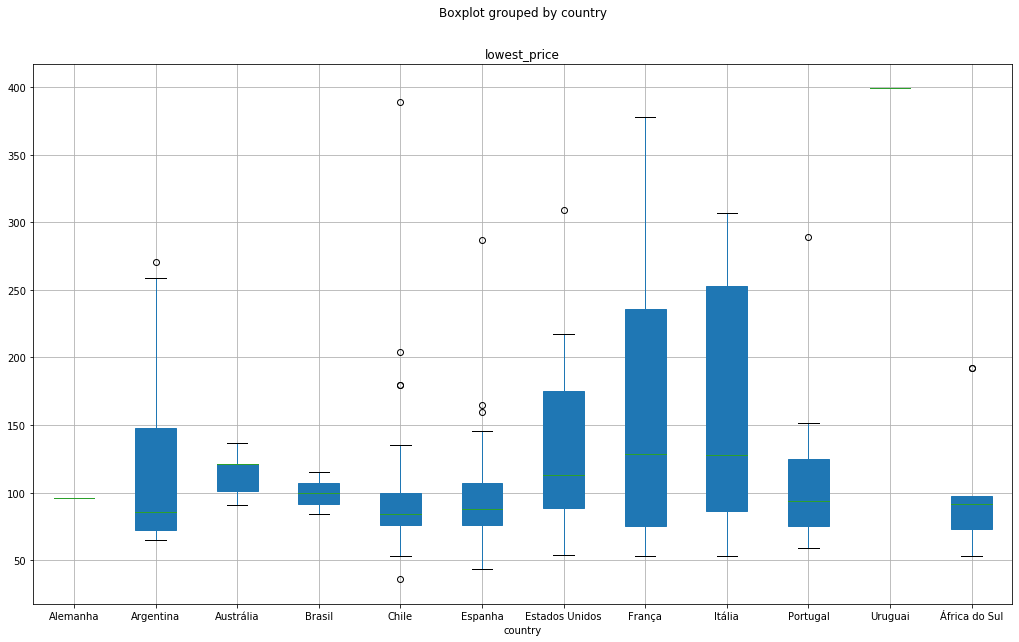

In [38]:
### Referencia: wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 200.0) & (wine_df.rating_count > 34.0)].boxplot(by='country',column=['lowest_price'], figsize=(15,10), patch_artist=True)

plot_df = work_df.loc[(work_df.lowest_price <= 400.0) & (work_df.vivino_rating >= work_df.vivino_rating.median())]
plot_df.boxplot(by='country',column=['lowest_price'], figsize=(17,10), patch_artist=True)

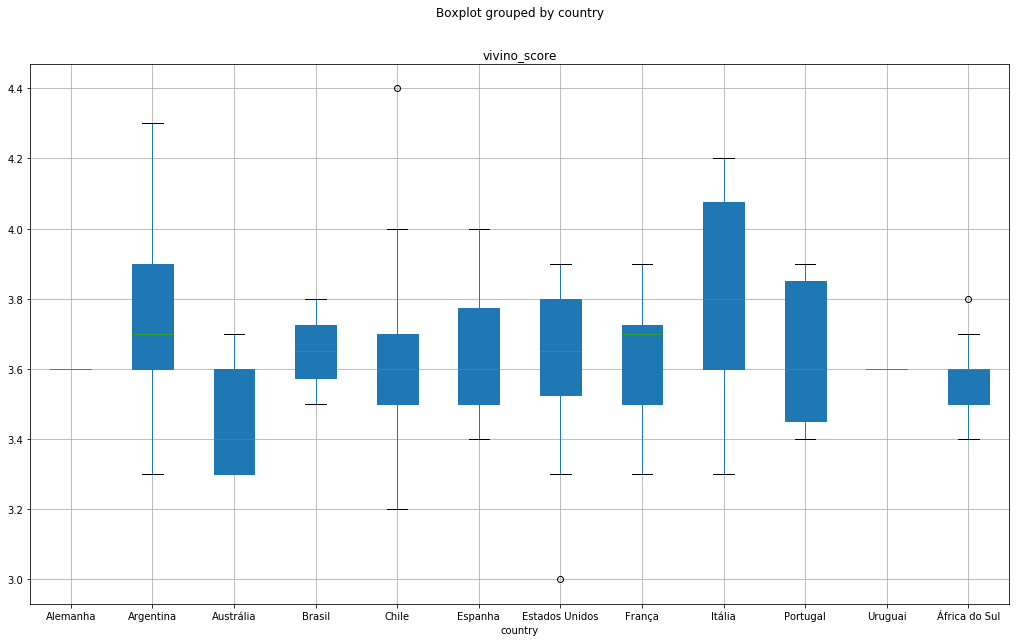

In [39]:
plot_df.boxplot(by='country',column=['vivino_score'], figsize=(17,10), patch_artist=True)

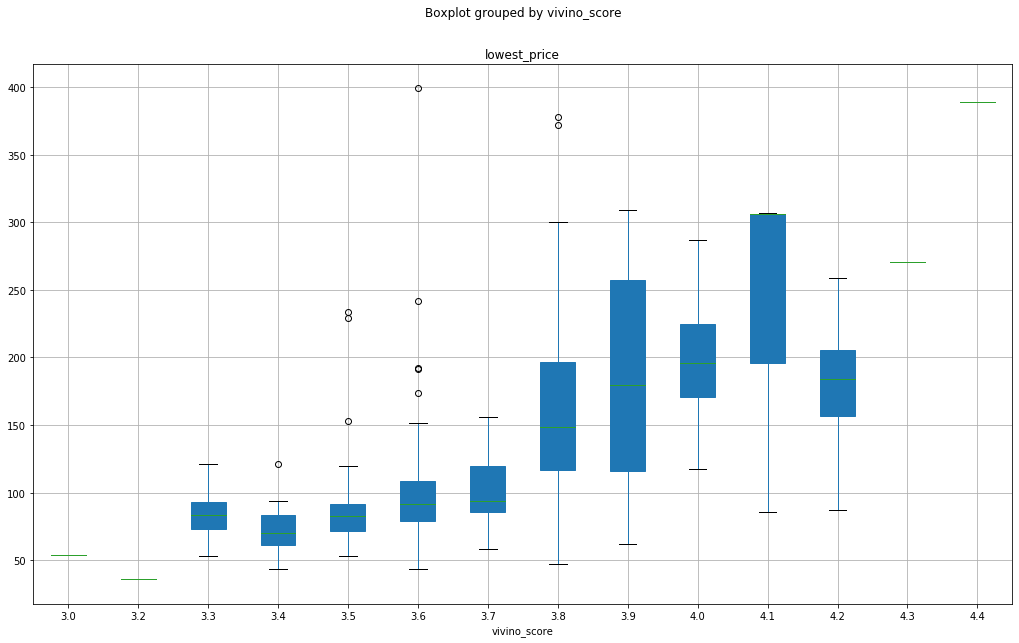

In [40]:
plot_df.boxplot(by='vivino_score',column=['lowest_price'], figsize=(17,10), patch_artist=True)

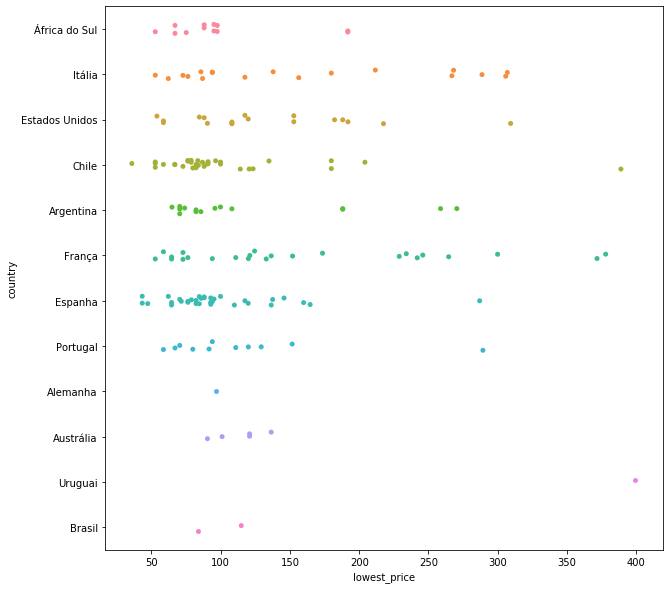

In [41]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.stripplot(x="lowest_price", y="country", data=plot_df, ax=ax, jitter= True)
plt.show()

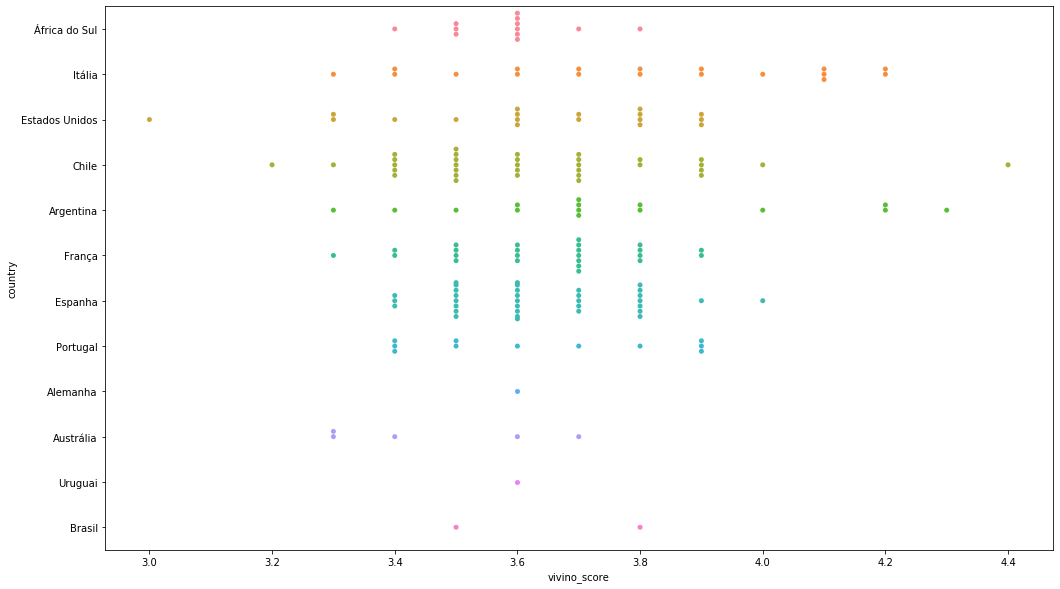

In [42]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="country", data=plot_df, ax=ax)
plt.show()

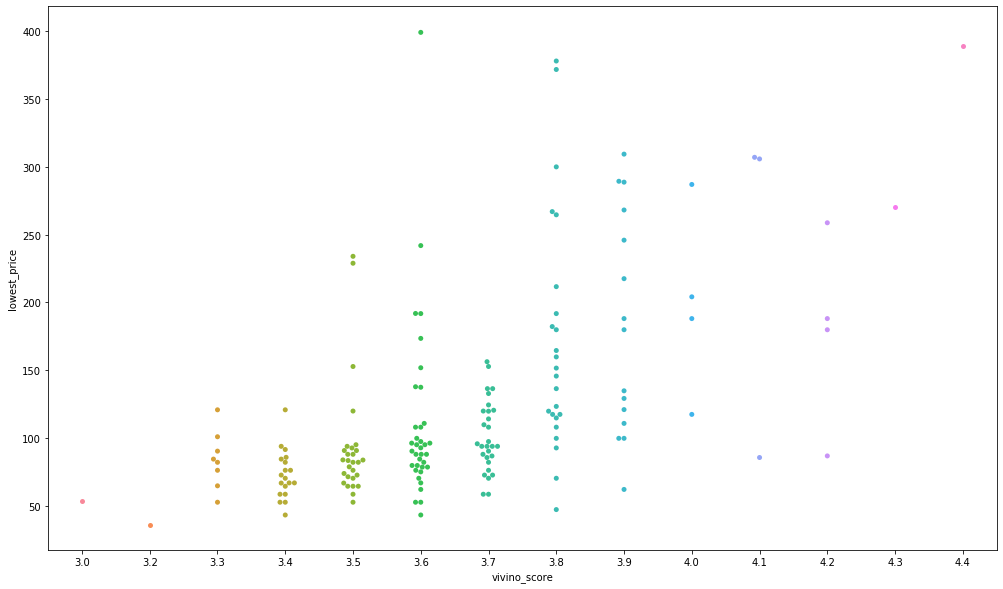

In [43]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="lowest_price", data=plot_df, ax=ax)
plt.show()

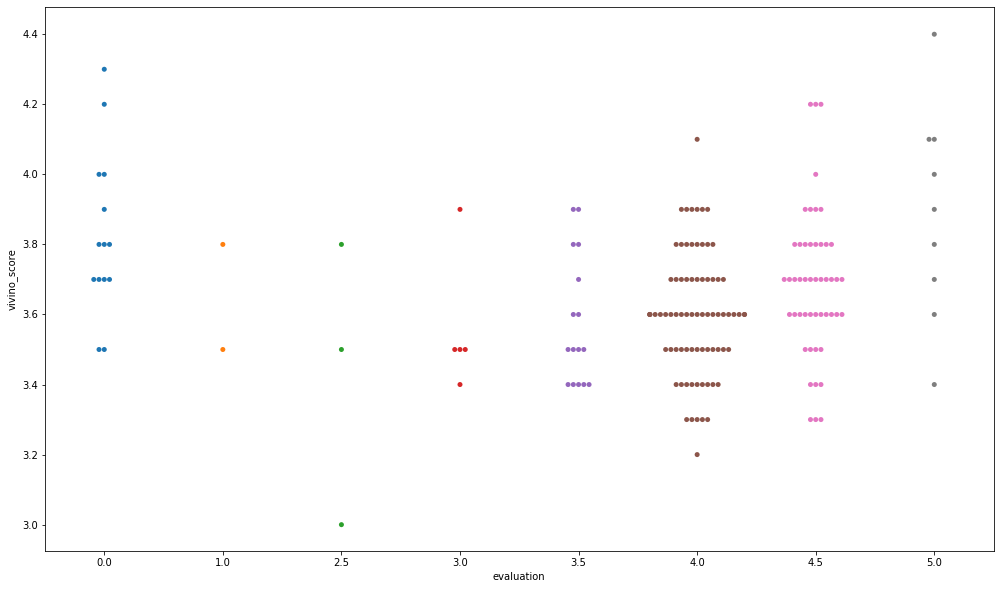

In [44]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="evaluation", y="vivino_score", data=plot_df, ax=ax)
plt.show()

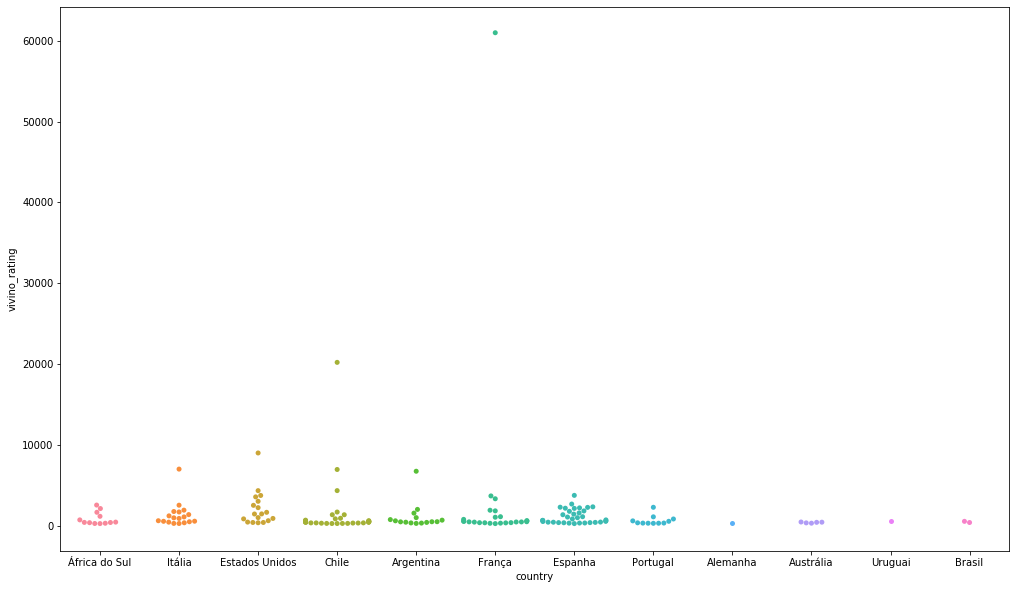

In [45]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="country", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

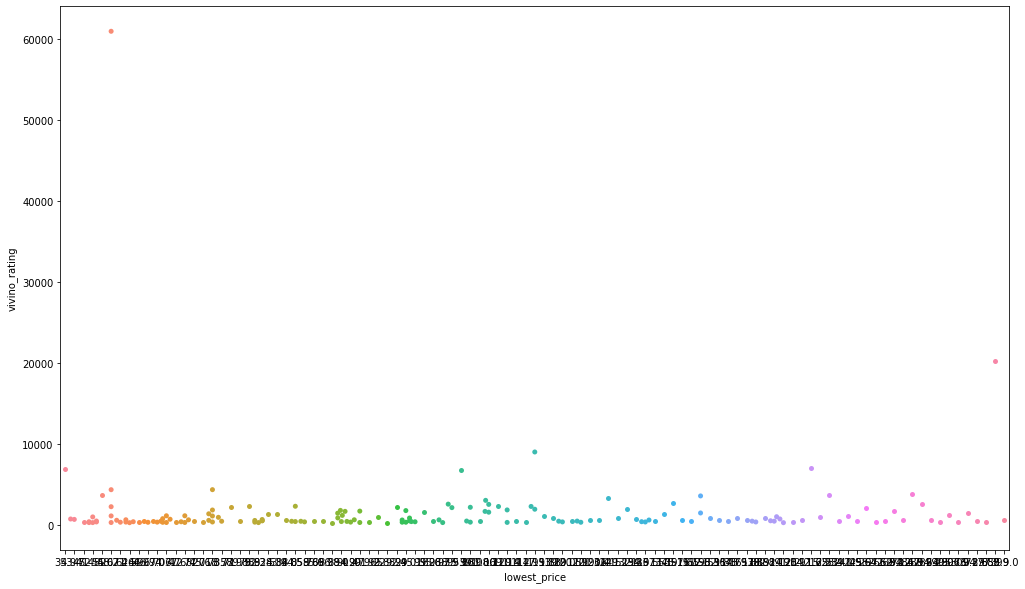

In [46]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="lowest_price", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

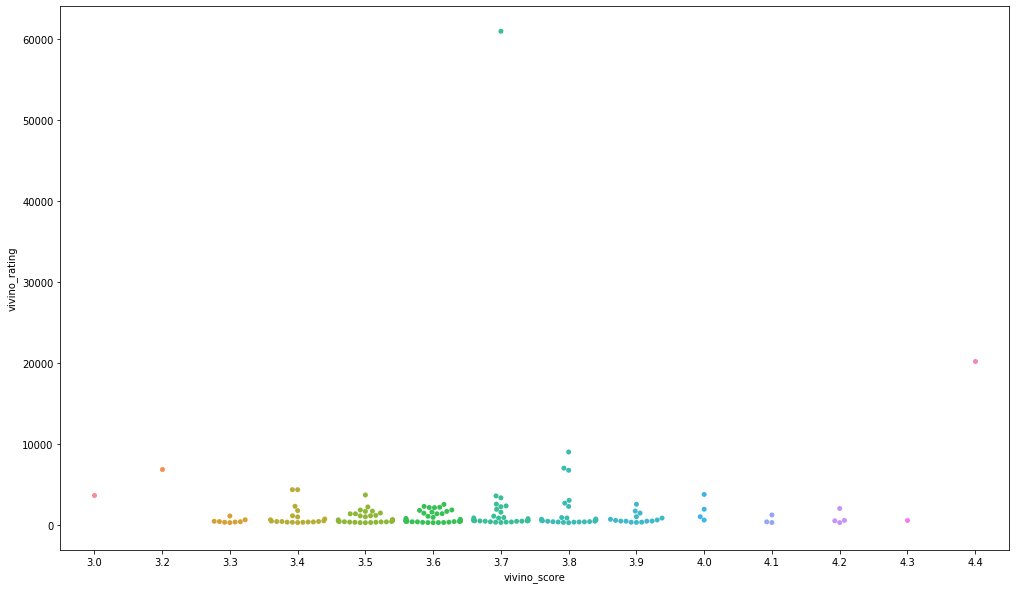

In [47]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

In [48]:
menor_preco = work_df.groupby(['country','vivino_score']).apply(lambda df: df.loc[df.lowest_price.idxmin()])
display(menor_preco)

wine_name  \
country       vivino_score                                                    
Alemanha      3.6               Ernst Loosen Pfalz Edition Pinot Blanc 2018   
              3.7                Ernst Loosen Private Reserve Riesling 2018   
              4.0                Ernst Loosen Pfalz Edition Dornfelder 2018   
Argentina     3.3                  Partridge Flying Cabernet Sauvignon 2019   
              3.4                          Cava Negra Chardonnay 375ml 2019   
...                                                                     ...   
África do Sul 4.0                                 Fleur Du Cap Laszlo 2015.   
              4.1                                     Marianne Floreal 2015   
              4.2                                  Fleur du Cap Laszlo 2014   
              4.3           Marianne Cape of Good Hope Sauvignon Blanc 2018   
Áustria       3.9                       Gruner Veltliner Classic White 2018   

                                                                         link  \
country       vivino_score                                                      
Alemanha      3.6           wine.com.br/vinhos/ernst-loosen-pfalz-edition-...   
              3.7           wine.com.br/vinhos/ernst-loosen-private-reserv...   
              4.0           wine.com.br/vinhos/ernst-loosen-pfalz-edition-...   
Argentina     3.3           wine.com.br/vinhos/partridge-flying-cabernet-s...   
              3.4           wine.com.br/vinhos/cava-negra-chardonnay-375ml...   
...                                                                       ...   
África do Sul 4.0           wine.com.br/vinhos/fleur-du-cap-laszlo-2015-/p...   
              4.1           wine.com.br/vinhos/marianne-floreal-2015/prod1...   
              4.2           wine.com.br/vinhos/fleur-du-cap-laszlo-2014/pr...   
              4.3           wine.com.br/vinhos/marianne-cape-of-good-hope-...   
Áustria       3.9           wine.com.br/vinhos/gruner-veltliner-classic-wh...   

                                  country    type  \
country       vivino_score                          
Alemanha      3.6                Alemanha  branco   
              3.7                Alemanha  branco   
              4.0                Alemanha   tinto   
Argentina     3.3               Argentina   tinto   
              3.4               Argentina  branco   
...                                   ...     ...   
África do Sul 4.0           África do Sul   tinto   
              4.1           África do Sul   tinto   
              4.2           África do Sul   tinto   
              4.3           África do Sul  branco   
Áustria       3.9                 Áustria  branco   

                                                                  description  \
country       vivino_score                                                      
Alemanha      3.6                              Frutado, leve, acidez presente   
              3.7                          Leve, boa acidez, cítrico, mineral   
              4.0             Frutado, leve, acidez agradável, taninos macios   
Argentina     3.3                 Frutado, fresco, taninos sedosos, bom corpo   
              3.4           Jovem, fresco, acidez agradável e sabores típi...   
...                                                                       ...   
África do Sul 4.0           Complexo, intenso, encorpado, acidez agradável...   
              4.1           Harmônico, estruturado, acidez agradável, tani...   
              4.2           Complexo, intenso, encorpado, acidez agradável...   
              4.3                  Complexo, médio corpo, boa acidez, cítrico   
Áustria       3.9                             Leve, jovem e com toque mineral   

                            evaluation  rating_count  lowest_price  \
country       vivino_score                                           
Alemanha      3.6                  4.0          18.0         95.18   
              3.7             

In [49]:
df = work_df.groupby(['country']).lowest_price.describe()

df[['count','mean','min','50%','max']]

,count,mean,min,50%,max
country,,,,,
Alemanha,5.0,93.530000,88.12,95.180,99.88
Argentina,62.0,102.045323,38.96,72.490,451.65
Austrália,8.0,116.036250,90.47,120.900,136.50
Brasil,5.0,127.320000,75.90,114.900,225.90
Chile,96.0,129.776771,35.90,85.745,1058.71
China,1.0,75.180000,75.18,75.180,75.18
Espanha,70.0,110.667714,43.41,85.245,777.53
Estados Unidos,36.0,589.181667,54.00,154.000,8938.71
França,96.0,1391.531562,52.82,208.710,15870.47


In [50]:
resumo_df = work_df[['lowest_price','vivino_score']].describe()
resumo_df = resumo_df.style.format({'lowest_price': "{:.2}"})
resumo_df

,lowest_price,vivino_score
count,4.9e+02,397.000000
mean,4.2e+02,3.698741
std,1.4e+03,0.302887
min,3.6e+01,2.900000
25%,7.6e+01,3.500000
50%,1e+02,3.600000
75%,1.8e+02,3.900000
max,1.6e+04,4.600000


In [9]:
marker_size = pd.qcut(work_df.vivino_rating, q=[0, .25, .5, .75, 1.] , labels= [6, 12, 18, 24])
marker_size

0       6.0
1       NaN
2       6.0
3       6.0
4      12.0
5      12.0
6      12.0
7      24.0
8       NaN
9      12.0
10     12.0
11      6.0
12     12.0
13      NaN
14     24.0
15     12.0
16      6.0
17      NaN
18     18.0
19      6.0
20     12.0
21     18.0
22     18.0
23      NaN
24      6.0
25     24.0
26     24.0
27     12.0
28      6.0
29     24.0
       ... 
234     6.0
235    24.0
236    12.0
237    12.0
238     NaN
239    12.0
240     6.0
241     6.0
242    12.0
243     6.0
244     6.0
245    24.0
246     NaN
247    24.0
248     6.0
249    12.0
250    18.0
251    18.0
252    12.0
253     6.0
254    12.0
255     6.0
256     6.0
257     6.0
258    12.0
259     6.0
260    12.0
261     6.0
262    18.0
263    12.0
Name: vivino_rating, Length: 264, dtype: category
Categories (4, int64): [6 < 12 < 18 < 24]